In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

import shap

In [5]:
path = 'https://stepik.org/media/attachments/lesson/779915/fs_task1_10f.csv'
df = pd.read_csv(path)

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


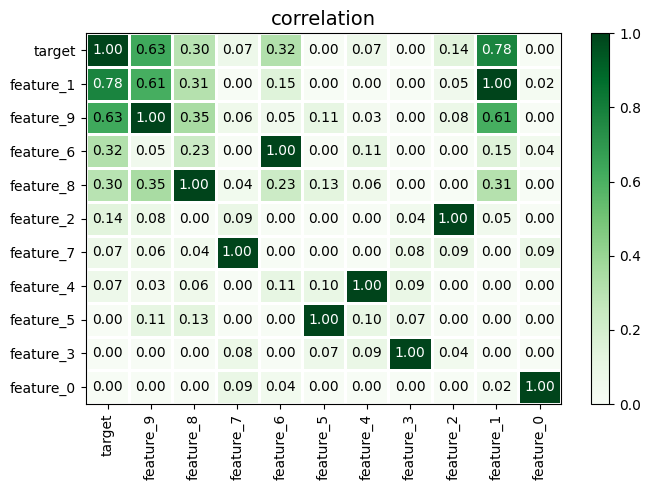

In [14]:
phik_overview = df.phik_matrix().round(2).sort_values('target')
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens')

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


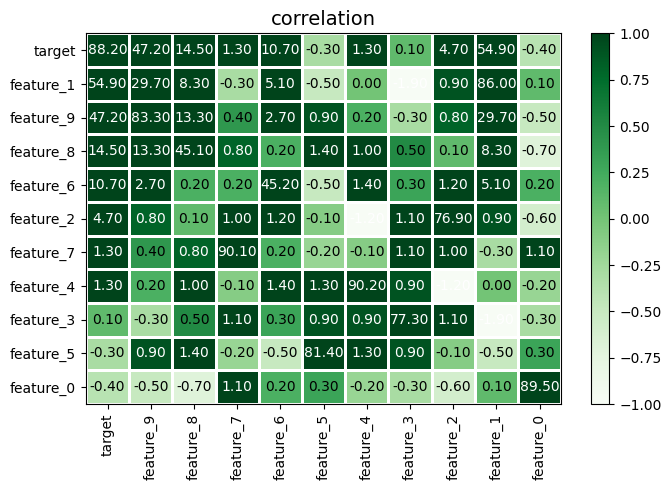

In [18]:
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target')
plot_correlation_matrix(significance_overview.values, x_labels=significance_overview.columns, y_labels=significance_overview.index, color_map='Greens')

In [19]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [20]:
drop_cols = ['target']
X = df.drop(columns=drop_cols)
y = df['target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [26]:
model = CatBoostClassifier(random_state=42)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, plot=False, early_stopping_rounds=50)

Learning rate set to 0.10885
0:	learn: 1.9397215	test: 1.9473294	best: 1.9473294 (0)	total: 79.4ms	remaining: 1m 19s
100:	learn: 0.4678663	test: 0.6483020	best: 0.6483020 (100)	total: 1.04s	remaining: 9.24s
200:	learn: 0.3304501	test: 0.6373796	best: 0.6366906 (199)	total: 1.99s	remaining: 7.93s
300:	learn: 0.2467960	test: 0.6428317	best: 0.6361299 (254)	total: 2.93s	remaining: 6.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6361299133
bestIteration = 254

Shrink model to first 255 iterations.


In [27]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,feature_1,32.490151
1,feature_9,29.112944
2,feature_8,12.172454
3,feature_2,4.631686
4,feature_6,4.100450
5,feature_7,3.807930
6,feature_5,3.795735
7,feature_4,3.491490
8,feature_3,3.473900
9,feature_0,2.923259


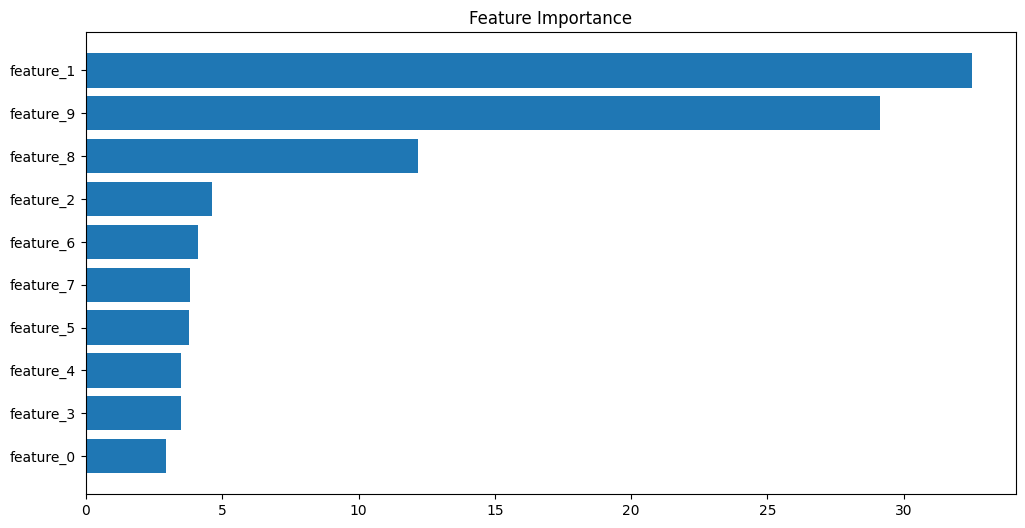

In [28]:
feature_imp = model.feature_importances_
sorted_idx = np.argsort(feature_imp)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

In [29]:
from sklearn.inspection import permutation_importance

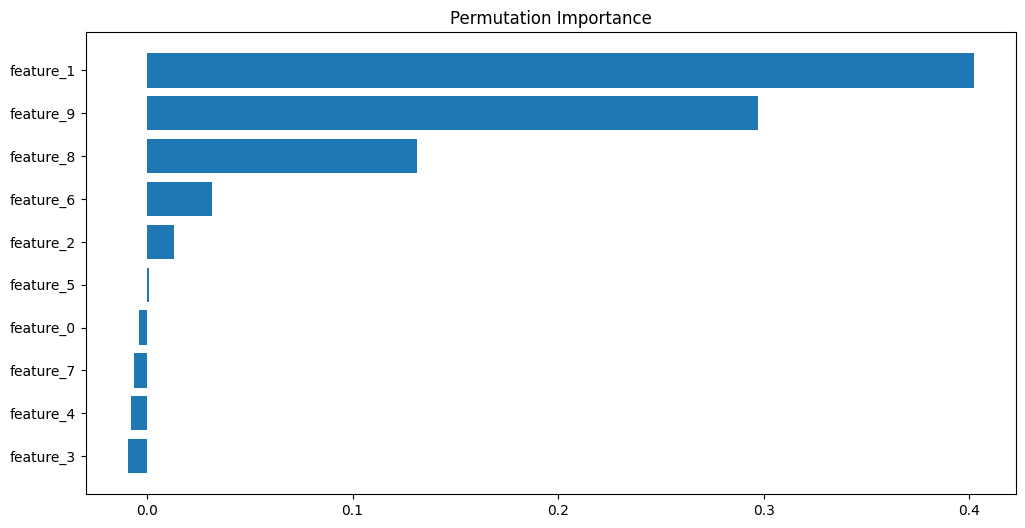

In [35]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [38]:
explainer = shap.TreeExplainer(model)

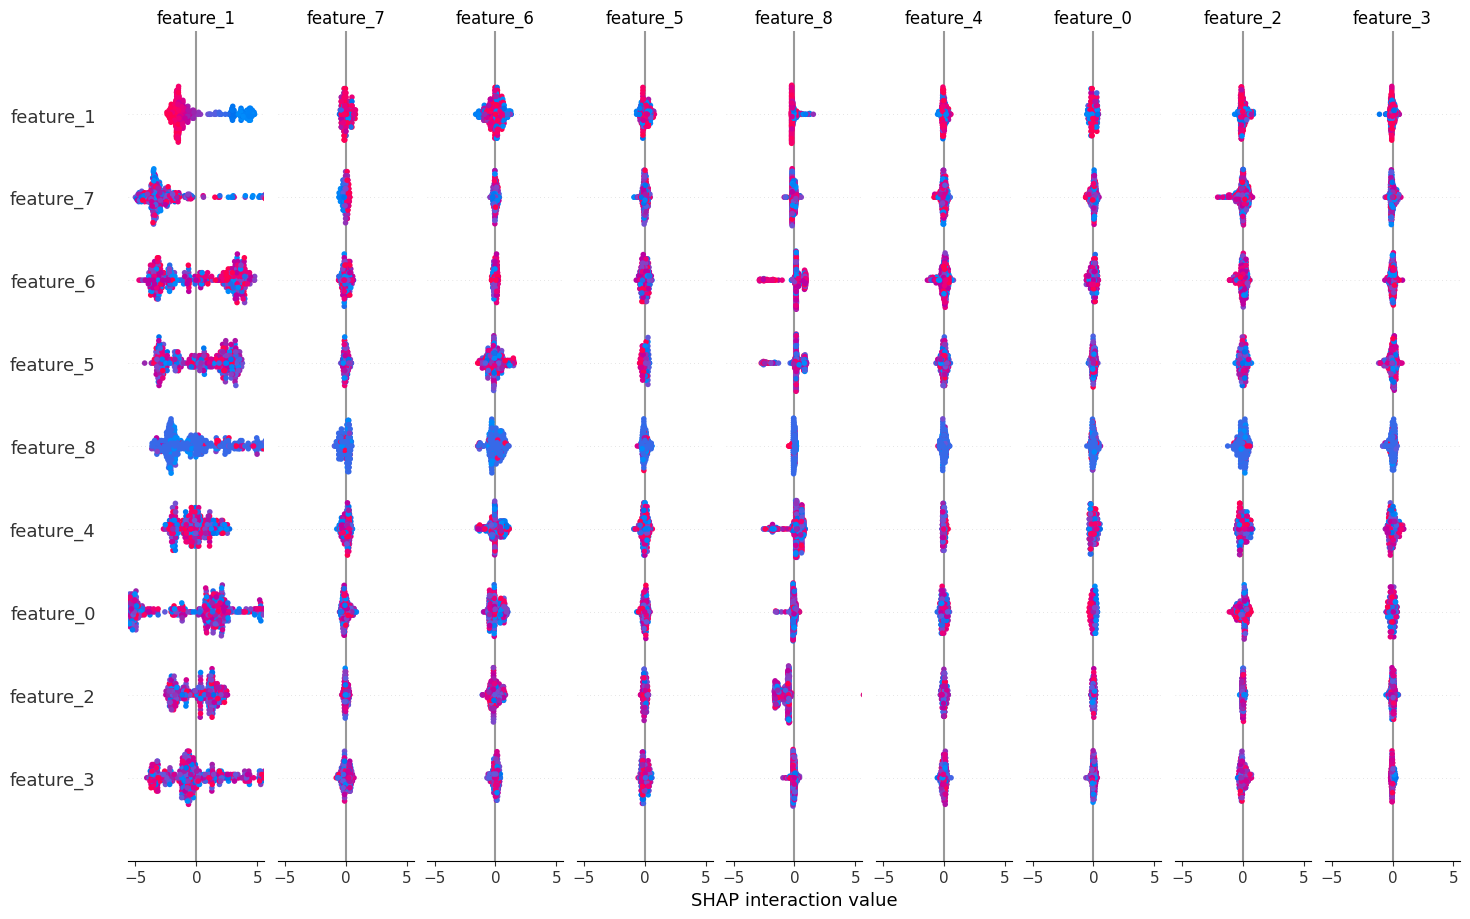

In [58]:
val_dataset = Pool(data=X_test, label=y_test)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=25)

In [48]:
model.select_features(X_train, y_train, eval_set=(X_test, y_test), features_for_select='0-8', num_features_to_select=8, train_final_model=False, logging_level='Silent', steps=1)

{'selected_features': [0, 1, 2, 3, 5, 6, 7, 8],
 'eliminated_features_names': ['feature_4'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1],
  'loss_values': [0.6361299132602128, 0.6262806907485204]},
 'eliminated_features': [4],
 'selected_features_names': ['feature_0',
  'feature_1',
  'feature_2',
  'feature_3',
  'feature_5',
  'feature_6',
  'feature_7',
  'feature_8']}

In [49]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [50]:
forest = RandomForestClassifier(max_depth=3)
boruta = BorutaPy(estimator=forest, n_estimators='auto', max_iter=8, verbose=1)
boruta.fit(X_train.values, y_train.values)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	5
Rejected: 	5


BorutaPy(estimator=RandomForestClassifier(max_depth=3, n_estimators=149,
                                          random_state=RandomState(MT19937) at 0x7059684F7440),
         max_iter=8, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7059684F7440, verbose=1)

In [56]:
green = X_train.columns[boruta.support_].tolist()
blue = X_train.columns[boruta.support_weak_].tolist()
red = X_train.columns[~(boruta.support_ | boruta.support_weak_)].tolist()
print('green: ', green)
print('blue: ', blue)
print('red: ', red)

green:  []
blue:  ['feature_1', 'feature_2', 'feature_6', 'feature_8', 'feature_9']
red:  ['feature_0', 'feature_3', 'feature_4', 'feature_5', 'feature_7']


In [52]:
boruta.*_?

boruta.__class__
boruta.__delattr__
boruta.__dict__
boruta.__dir__
boruta.__doc__
boruta.__eq__
boruta.__format__
boruta.__ge__
boruta.__getattribute__
boruta.__getstate__
boruta.__gt__
boruta.__hash__
boruta.__init__
boruta.__init_subclass__
boruta.__le__
boruta.__lt__
boruta.__module__
boruta.__ne__
boruta.__new__
boruta.__reduce__
boruta.__reduce_ex__
boruta.__repr__
boruta.__setattr__
boruta.__setstate__
boruta.__sizeof__
boruta.__sklearn_clone__
boruta.__str__
boruta.__subclasshook__
boruta.__version__
boruta.__weakref__
boruta.importance_history_
boruta.n_features_
boruta.ranking_
boruta.support_
boruta.support_weak_

/home/mic/Downloads/Python
